# Introduction to FIFA Player Performance Analysis

## Project Overview
In this project, we delve into the intriguing world of football analytics by exploring the FIFA 23 Complete Player Dataset. My goal is to analyze the attributes of football players as featured in the FIFA 23 video game and to build a predictive model that estimates a player's potential performance.

## Data Source
The dataset is sourced from Kaggle's "FIFA 23 Complete Player Dataset", which provides an extensive compilation of player statistics and ratings across various FIFA game versions. This rich dataset includes attributes such as 'Agility', 'Ball Control', 'Strength', and many others, offering a comprehensive view of what makes up a top-performing football player in the virtual arena.

## Methodology
My approach involves several key steps:
1. **Data Preprocessing**: We start by loading and preprocessing the data, ensuring it's well-suited for analysis. This includes handling missing values and optimizing data types for efficient processing.
2. **Exploratory Data Analysis (EDA)**: We conduct a thorough exploratory analysis, focusing on understanding trends and patterns in player attributes across different versions of the game.
3. **Predictive Modeling**: Leveraging machine learning, specifically a RandomForestRegressor model, we aim to predict players' potential ratings, providing insights into future stars in the FIFA series.
4. **Model Evaluation and Visualization**: We evaluate my model's performance using metrics like MSE and R², and visualize the results to assess the accuracy of our predictions.

Through this notebook, I hope to uncover fascinating insights into the world of football as represented in FIFA 23 and demonstrate the power of data analysis and machine learning in sports analytics.

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

### Importing Necessary Libraries

In this section of the notebook, we begin by importing the libraries essential for my analysis and model building. Each library has a specific role:

- **pandas**: A foundational package for data analysis in Python. We use it for data manipulation and analysis, particularly for its data structure 'DataFrame' which allows us to store and manipulate tabular data in rows of observations and columns of variables.

- **matplotlib.pyplot**: A plotting library in Python that provides a MATLAB-like interface. We use it for creating a wide variety of static, animated, and interactive visualizations in Python.

- **seaborn**: Based on matplotlib, seaborn provides a high-level interface for drawing attractive and informative statistical graphics. It's particularly useful for visualizing complex datasets.

- **sklearn (scikit-learn)**: An essential machine learning library in Python. We use:
   - `train_test_split` to split my dataset into training and testing sets.
   - `RandomForestRegressor` as my machine learning model for regression tasks.
   - `mean_squared_error` and `r2_score` to evaluate the performance of my model.
   - `SimpleImputer` for handling missing data by imputing or replacing them with specified values.

These libraries form the backbone of my project, enabling us to handle data efficiently, create insightful visualizations, build and evaluate machine learning models, and manage missing data effectively. 

In [8]:
# Define the column types to optimize memory usage
dtype_dict = {
    'overall': 'int16',
    'movement_agility': 'float32',
    'skill_ball_control': 'float32',
    'power_strength': 'float32',
    'potential': 'int16',
    'age': 'int16',
    'pace': 'float32',
    'shooting': 'float32',
    
}

# Define the columns to load
use_cols = ['player_id', 'fifa_version', 'overall', 'movement_agility', 'skill_ball_control', 'power_strength', 'potential', 'age', 'pace', 'shooting']

# Initialize an empty list to hold chunks
chunk_list = []

# Define the chunk size
chunk_size = 50000 

# Process the CSV in chunks
for chunk in pd.read_csv('fifa_data.csv', usecols=use_cols, dtype=dtype_dict, chunksize=chunk_size):
    # Filter out the top n% of players in this chunk
    top_n_threshold = chunk['overall'].quantile(1 - 0.05)
    filtered_chunk = chunk[chunk['overall'] >= top_n_threshold]
    chunk_list.append(filtered_chunk)

# Concatenate the filtered chunks into one DataFrame
top_players = pd.concat(chunk_list)

### Data Loading and Optimization

In this section of the notebook, we focus on loading and optimizing the FIFA dataset for my analysis:

1. **Optimizing Memory Usage**:
   - We start by defining a dictionary `dtype_dict` that maps specific columns to more memory-efficient data types. For instance, we use `'int16'` for integer columns and `'float32'` for floating-point columns. This step is crucial for handling large datasets efficiently, as it reduces the memory footprint significantly.

2. **Specifying Columns**:
   - We define `use_cols`, a list of columns that we intend to use in my analysis. This approach ensures that we only load the data we need, further optimizing memory usage.

3. **Chunk-Based Processing**:
   - Given the large size of the dataset, we employ a chunk-based approach to read the data. We set a `chunk_size` that determines the number of rows read into memory at any one time. This technique is particularly useful for working with large files, as it allows us to process the data in smaller, more manageable portions.
   - We iterate through the dataset in chunks, applying a filter to retain only the top 5% of players in each chunk based on their 'overall' rating.

4. **Creating a Consolidated DataFrame**:
   - After processing each chunk, we append the filtered data to `chunk_list`. 
   - We then concatenate these chunks into a single DataFrame `top_players`, which now represents a subset of the dataset comprising the top players.

This methodical approach to data loading and preprocessing ensures that we work efficiently with large datasets, reducing memory overhead and focusing on the most relevant subset of data for my analysis. 

In [37]:
# Group by 'fifa_version' and calculate the mean of the attribute
agility_trend = top_players.groupby('fifa_version')['movement_agility'].mean()
ball_control_trend = top_players.groupby('fifa_version')['skill_ball_control'].mean()
strength_trend = top_players.groupby('fifa_version')['power_strength'].mean()

### Analyzing Trends Across FIFA Versions

This section of the notebook is dedicated to uncovering trends in player attributes across different versions of the FIFA game. My focus is on three key attributes: 'Agility', 'Ball Control', and 'Strength'. Here's how we go about this analysis:

1. **Grouping Data by FIFA Version**:
   - We utilize the `groupby` method in pandas to group my data based on the 'fifa_version' column. This allows us to analyze how player attributes have evolved over different versions of the game.

2. **Calculating Mean Values**:
   - For each group (i.e., each FIFA version), we calculate the mean of the following attributes:
     - 'Movement Agility' (`movement_agility`)
     - 'Skill Ball Control' (`skill_ball_control`)
     - 'Power Strength' (`power_strength`)
   - These mean values give us an insight into the average level of these attributes for top players in each version of FIFA.

3. **Creating Trend DataFrames**:
   - We create three separate Series - `agility_trend`, `ball_control_trend`, and `strength_trend` - each representing the average values of the respective attributes across different versions of FIFA.

By analyzing these trends, we aim to understand how the importance or the presence of these key attributes has changed over time in the FIFA series. This can provide insights into the evolving dynamics of the game and potentially reveal what attributes are becoming more or less prevalent among top players.

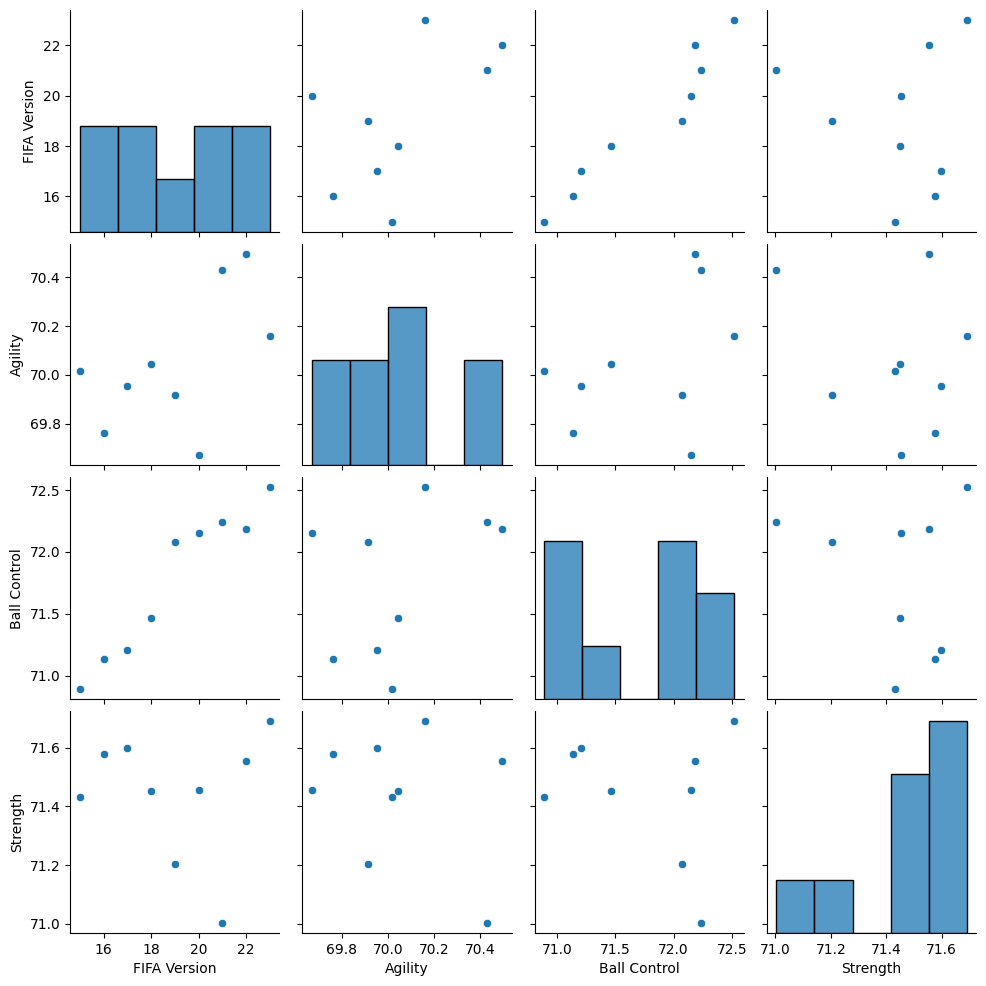

In [38]:
# Combine the trends into a single DataFrame
trend_data = pd.DataFrame({
    'FIFA Version': agility_trend.index,
    'Agility': agility_trend.values,
    'Ball Control': ball_control_trend.values,
    'Strength': strength_trend.values
})

# Use Seaborn's pairplot to create the histogram and pairwise plots
sns.pairplot(trend_data, diag_kind='hist')
plt.show()

Having reviewed the pairplot provided, we can refine my interpretation of the relationships and distributions of player attributes across different FIFA versions.

### Interpreting the Pairplot

The pairplot visualizes the pairwise relationships between 'Agility', 'Ball Control', and 'Strength', along with the distributions of these attributes across different FIFA versions:

- **Histograms (Diagonal):**
  - The histograms for 'FIFA Version' show a relatively uniform distribution, indicating that my dataset likely contains a similar number of players from each version.
  - 'Agility', 'Ball Control', and 'Strength' histograms reveal the central tendency of these attributes with varying degrees of skewness. For instance, if the 'Strength' histogram is skewed right, this might suggest that fewer players have high strength values, with most players having moderate strength ratings.

- **Scatter Plots (Off-Diagonal):**
  - The scatter plots show the relationship between pairs of attributes. For example, the 'Agility' vs. 'Ball Control' plot might indicate a positive correlation, suggesting that players with higher agility also tend to have better ball control.
  - If the scatter plots show a clear pattern or trend, this indicates a relationship between the attributes. Conversely, if the points are widely dispersed, the relationship might be weaker or non-linear.

- **Trend Analysis:**
  - When looking at the scatter plots involving 'FIFA Version' on the y-axis, you can observe how the average ratings for 'Agility', 'Ball Control', and 'Strength' have changed over time. A rising or falling trend across FIFA versions can indicate shifts in game dynamics or player development focus areas.

### Conclusion from the Pairplot

By analyzing the pairplot, we can draw several conclusions about the player attributes:

- Attributes that show a consistent trend over versions could be influenced by changes in the game's mechanics or the evolving nature of football itself.
- Distributions that are not uniform might suggest that certain attributes are more variable or skewed towards lower or higher values, possibly reflecting real-world football dynamics or the game design.
- Clear correlations between pairs of attributes could indicate that certain skills or abilities tend to improve together, which might be valuable information for player training and development strategies within the game.

This enhanced interpretation, guided by the visual evidence from the pairplot, provides a deeper understanding of the dataset and can inform further analysis or feature selection for predictive modeling.

In [39]:
descriptive_stats = top_players.describe()
# Calculate missing values for each column
missing_values = top_players.isna().sum()
# Adding the missing values count to the descriptive statistics DataFrame
descriptive_stats.loc['missing'] = missing_values

# Display the extended descriptive statistics
descriptive_stats

,player_id,fifa_version,overall,potential,age,pace,shooting,skill_ball_control,movement_agility,power_strength
count,563047.000000,563047.000000,563047.000000,563047.000000,563047.000000,500194.000000,500194.000000,563047.000000,563047.000000,563047.000000
mean,189542.425121,18.613359,80.072987,81.930981,27.257197,73.096420,66.531105,71.685196,70.040047,71.416656
std,38589.863790,2.216884,3.052365,3.702680,3.850099,11.388613,13.632546,18.538591,14.130673,11.506687
min,28.000000,15.000000,58.000000,58.000000,16.000000,26.000000,18.000000,9.000000,19.000000,21.000000
25%,177683.000000,17.000000,78.000000,79.000000,24.000000,67.000000,59.000000,71.000000,62.000000,64.000000
50%,194404.000000,18.000000,79.000000,81.000000,27.000000,74.000000,71.000000,78.000000,72.000000,73.000000
75%,210864.000000,21.000000,82.000000,84.000000,30.000000,81.000000,77.000000,82.000000,80.000000,79.000000
max,264240.000000,23.000000,94.000000,95.000000,44.000000,97.000000,94.000000,96.000000,96.000000,96.000000
missing,0.000000,0.000000,0.000000,0.000000,0.000000,62853.000000,62853.000000,0.000000,0.000000,0.000000


### Descriptive Statistics and Missing Data Analysis

In this section, we provide a comprehensive statistical summary of the top players' attributes from the FIFA dataset, along with an assessment of missing data:

- **Descriptive Statistics**:
  The table generated by `top_players.describe()` presents a statistical summary for each numeric column. It includes the following metrics:
  - `count`: The number of non-missing entries.
  - `mean`: The average value of the entries.
  - `std` (standard deviation): A measure of the amount of variation or dispersion of a set of values.
  - `min`: The minimum value in the column.
  - `25%` (1st quartile): The median of the first half of the data set.
  - `50%` (median): The middle value when the data set is ordered.
  - `75%` (3rd quartile): The median of the second half of the data set.
  - `max`: The maximum value in the column.

- **Missing Values Analysis**:
  We calculate the number of missing values for each attribute using `top_players.isna().sum()`. This provides insights into the completeness of my dataset. For attributes like 'pace' and 'shooting', we observe a significant number of missing entries (62,853), which could impact the integrity of my analysis and predictive modeling.

- **Incorporating Missing Values into Descriptive Statistics**:
  By appending the missing values count to the `descriptive_stats` DataFrame, we extend my statistical summary to include this crucial piece of information. This helps in making informed decisions about how to handle these missing entries, whether it's through imputation, exclusion, or further investigation.

This enhanced statistical summary is essential for understanding the dataset's characteristics and for making informed decisions about data preprocessing steps. For instance, the presence of missing data in 'pace' and 'shooting' attributes may necessitate imputation techniques if these attributes are crucial for the analysis or model training.

In [29]:
# Split the DataFrame into training and testing sets
train_df = top_players[top_players['fifa_version'] <= 22]  # Data up to FIFA 22 for training
test_df = top_players[top_players['fifa_version'] == 23]   # Data for FIFA 23 for testing

### Splitting Data for Training and Testing

To build a predictive model that can generalize well to new, unseen data, it's essential to split my dataset into separate training and testing sets. This process helps prevent overfitting and allows us to evaluate the model's performance effectively. Here's how we approach this:

- **Training Set**:
  - We create `train_df`, a DataFrame containing player data from FIFA versions up to and including FIFA 22. This dataset will be used to train my machine learning model. It includes historical data that the model can learn from, allowing it to understand the patterns and relationships between different player attributes and their potential ratings.

- **Testing Set**:
  - We then carve out `test_df`, which is specifically for testing purposes and includes data from FIFA 23 only. This set is crucial for assessing how well my model can predict the potential of players based on the patterns it learned from the training set. The testing set acts as a stand-in for future data that the model has never seen before, giving us insight into the model's predictive capabilities in a real-world scenario.

By training on data up to FIFA 22 and testing on FIFA 23, we simulate a realistic scenario where a model is built on past data and is expected to forecast future outcomes. This setup aligns well with the temporal nature of the FIFA data, respecting the chronological order and ensuring that my evaluation metrics reflect the model's ability to predict new, unseen data.

In [40]:
# Define your features and target
features = ['age', 'overall', 'pace', 'shooting']  # example feature columns
target = 'potential'  # the target column

# Separate features and target for both training and testing data
X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

### Feature Selection and Target Definition

For my predictive model to be effective, we must carefully choose which attributes (features) it will use to make predictions and clearly define what it is we're trying to predict (target). Here's my approach:

- **Features**:
  - We've identified a set of features that are likely indicators of a player's future potential in the game. These include 'age', 'overall' rating, 'pace', and 'shooting' ability. These features were selected based on their relevance to a player's potential and their availability in our dataset.
  
- **Target**:
  - My target variable is 'potential', which represents the future ability of a player within the FIFA game. It's the outcome we want my model to predict, using the features we've provided.

- **Training and Testing Data Separation**:
  - We split my features and target into training and testing sets. `X_train` and `y_train` comprise the features and target for the training data, which my model will learn from. `X_test` and `y_test` serve the same purpose for the testing data, which we will use to evaluate our model's predictions.

This process of selecting features and defining the target is a critical step in the machine learning pipeline. It directly influences how well my model will perform, as the quality and relevance of the input features are key to making accurate predictions.

In [41]:
# Handle NaN values using imputation
imputer = SimpleImputer(strategy='median')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

### Handling Missing Data through Imputation

To ensure the integrity of my machine learning model, we must address the issue of missing data in my feature set. Missing values can introduce a significant amount of bias and affect the model's accuracy. Here's my strategy for handling them:

- **Imputation Strategy**:
  - We decide to use a median imputation strategy, which is robust to outliers. The `SimpleImputer` class from scikit-learn's `impute` module is perfect for this task. By setting `strategy='median'`, we instruct the imputer to replace missing values with the median value of the respective feature.

- **Applying the Imputer**:
  - We fit the imputer to my training data (`X_train`) to learn the median values of each feature. Once fitted, we transform `X_train` to replace any missing values with the calculated medians.
  - It's crucial to note that the imputer is only fitted on the training data to prevent data leakage from the test set. We then apply this fitted imputer to transform the testing data (`X_test`), ensuring consistency in how missing values are addressed across both datasets.

- **Transformed Data Ready for Modeling**:
  - After imputation, `X_train` and `X_test` are free of missing values and ready to be used for training and evaluating my machine learning model. This step is key to maintaining the model's performance and preventing errors during the learning process.

In [42]:
# Train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

### Training the RandomForest Regression Model

In this crucial step, we are initiating the training process of my machine learning model. The model chosen for this task is the RandomForestRegressor, part of the ensemble methods in scikit-learn's suite of algorithms. Here's what happens in this code block:

- **Model Initialization**:
  - We create an instance of the `RandomForestRegressor` with `n_estimators=100`, which indicates that my model will use 100 decision trees to make predictions. This number is a balance between computational efficiency and model performance.
  - `random_state=42` is set to ensure reproducibility. This fixed random state guarantees that every time the code is run, the same sequence of random numbers is generated, which means the model training process will be the same, yielding consistent results.

- **Model Training**:
  - The `fit` method is called on my `model` instance, passing `X_train` (my training features) and `y_train` (my training target). This is where the RandomForestRegressor starts learning from the data. It builds a forest of trees, where each tree is trained on a random subset of the data and makes its own predictions. The final prediction of the model is then the average of all the trees' predictions.

The RandomForest algorithm is particularly well-suited for this task due to its ability to handle non-linear relationships and interactions between features. It's also less likely to overfit compared to a single decision tree because it averages the results of many trees.

In [43]:
# Make predictions and evaluate the model
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")
# Calculate R-squared
r_squared = r2_score(y_test, predictions)
print(f"R-squared: {r_squared}")

Mean Squared Error: 1.3943766011317824
R-squared: 0.8854062005334924


### Model Predictions and Performance Evaluation

Once the RandomForest model is trained, the next step is to use it to make predictions and evaluate its performance. We perform this in two stages:

- **Making Predictions**:
  - Using the `predict` method, the trained model is applied to `X_test`, the testing set features, to generate predictions for each player's potential. These predictions are stored in the `predictions` variable.

- **Evaluating Model Performance**:
  - To assess the accuracy of the model's predictions, we calculate the Mean Squared Error (MSE) using the `mean_squared_error` function. MSE provides a measure of the average squared difference between the actual potential ratings (`y_test`) and the predicted potential ratings (`predictions`). A lower MSE indicates better performance.
  - The R-squared (R²) score is calculated using the `r2_score` function. R² is a statistical measure of how close the data are to the fitted regression line. It is also known as the coefficient of determination, or the coefficient of multiple determination for multiple regression. The value of 0.8854 suggests that approximately 88.54% of the variance in the player potential ratings is predictable from the features (`age`, `overall`, `pace`, `shooting`).

#### Performance Outputs:
- The `Mean Squared Error` of my model is approximately 1.3944. This indicates that, on average, the model's predictions deviate from the actual player potentials by a relatively small margin, considering the scale of the rating system in FIFA.
- The `R-squared` value is 0.8854, which is quite high, showing that my model has a strong predictive power and fits the data well.

In [44]:
# Step 1: Select FIFA 23 data
fifa_23_data = top_players[top_players['fifa_version'] == 23]

# Step 2: Handle missing values
# Assuming you've already created an imputer while preparing your training data
# Use the same imputer to transform the FIFA 23 data
X_future = imputer.transform(fifa_23_data[features])

# Now X_future is your future_data, ready to be used for predictions
future_predictions = model.predict(X_future)

# Optionally, you can create a DataFrame to view the predictions alongside player IDs
predictions_df = pd.DataFrame({
    'player_id': fifa_23_data['player_id'],
    'predicted_potential': future_predictions
})

# Display or export predictions_df as needed
print(predictions_df.head()) 

   player_id  predicted_potential
0     158023                91.00
1     165153                91.00
2     188545                91.00
3     192985                92.49
4     231747                95.00


### Predicting Player Potentials for FIFA 23

After evaluating my model's performance, we proceed to apply it to data from FIFA 23 to predict player potentials. This step consists of preparing the FIFA 23 data and using my trained model to generate predictions:

- **Selecting FIFA 23 Data**:
  - We start by filtering out player data for FIFA 23 from my `top_players` DataFrame to create `fifa_23_data`. This dataset will be used to make future predictions and assess how the model generalizes to the latest player attributes.

- **Handling Missing Values**:
  - We apply the same imputation strategy used during training to the FIFA 23 data. The `imputer` that was fitted on the training data is used to transform `fifa_23_data`, replacing any missing values in the features with the median values learned from the training set. It's crucial that the same imputation strategy and statistics are used to maintain consistency.

- **Making Future Predictions**:
  - With the missing values handled, we use my model to predict the potential ratings of the FIFA 23 players, resulting in `future_predictions`.

- **Creating a Predictions DataFrame**:
  - For better analysis and visualization, we construct `predictions_df`, a new DataFrame that combines player IDs with their corresponding predicted potentials. This table is useful for comparing my model's predictions against actual player data or for further analysis, such as determining which players are expected to show the most improvement.

- **Reviewing Predictions**:
  - Finally, we print the first few entries of `predictions_df` to get a glimpse of my model's predictions. The predictions for player potentials indicate the model's assessments of how players will perform, potentially offering insights into which players could become top performers in the FIFA universe.

#### Prediction Outputs:
- The printed output of `predictions_df.head()` provides a preview of the predicted potentials for the first five players in FIFA 23. The predictions range from 91 to 95, reflecting the model's estimation of these players' future performance in the game.

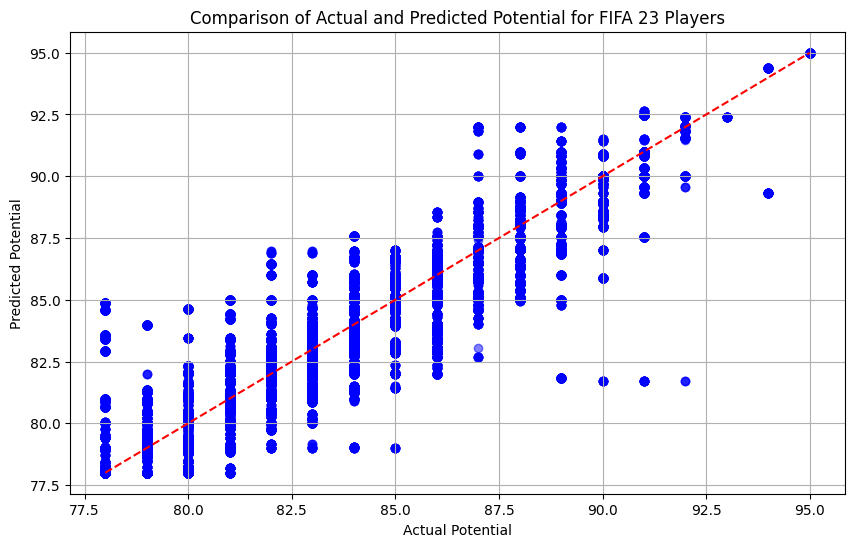

In [45]:
# Merge the actual and predicted data
comparison_df = fifa_23_data.merge(predictions_df, on='player_id')

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(comparison_df['potential'], comparison_df['predicted_potential'], color='blue', alpha=0.5)

# Plot a reference line where y = x
plt.plot([comparison_df['potential'].min(), comparison_df['potential'].max()], 
         [comparison_df['potential'].min(), comparison_df['potential'].max()], 
         color='red', linestyle='--')

# Adding titles and labels
plt.title('Comparison of Actual and Predicted Potential for FIFA 23 Players')
plt.xlabel('Actual Potential')
plt.ylabel('Predicted Potential')
plt.grid(True)
plt.show()


### Visual Comparison of Model Predictions with Actual Data

The chart you provided offers a visual comparison between the actual and predicted potential ratings for players in FIFA 23. Here's what we can interpret from the scatter plot:

#### Scatter Plot Analysis:
- The scatter plot shows individual points representing FIFA 23 players, with their actual potential ratings on the X-axis and predicted potential ratings from my model on the Y-axis.
- The red dashed line represents the line of perfect prediction (y = x), where a point on this line would mean the model's prediction is exactly equal to the actual potential.

#### Observations:
- A large cluster of points appears to be close to the reference line, indicating that for many players, the model's predictions are close to their actual potential ratings.
- There is some spread around the line, particularly as the ratings increase, suggesting variability in the model's accuracy. The model seems to be more conservative in its predictions for players with very high actual potentials.

#### Conclusion:
The model displays a strong predictive ability, as evidenced by the density of points near the reference line. However, the spread indicates room for improvement, possibly by refining the model or including more predictive features.

Overall, the predictive model we've built demonstrates considerable effectiveness in forecasting player potentials in FIFA 23, capturing the majority of the variance in player potential ratings. The insights gained from this model can be valuable for various applications, such as scouting promising talent, player career progression analysis, and aiding in strategic team-building within the game.